<a href="https://colab.research.google.com/github/DommiiUdomp/-/blob/main/EuroSatCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EuroSat dataset

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



Import the data

In [3]:
#if download from zip
import zipfile
import io
import requests
from PIL import Image

# RGB file URL
url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"

# download zip
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

# get file names
txtfiles = []
for file in z.namelist():
  txtfiles.append(file)

# keep only those containing ".jpg"
txtfiles = [x for x in txtfiles if ".jpg" in x]

In [ ]:
# read images to numpy array
XImages = np.zeros([len(txtfiles), 64, 64, 3])

i = 0
for pic in txtfiles:
  XImages[i] = np.asarray(Image.open(z.open(pic))).astype('uint8')/255
  print(i)
  i += 1

del r # clear memory
del z 

In [5]:
# Get labels in numpy array as strings
Ylabel = np.empty(len(txtfiles), dtype = 'S20')

i = 0
for label in txtfiles:
  Ylabel[i] = label.split('/')[1]
  i += 1

In [6]:
print(XImages.shape)
print(Ylabel.shape)

(27000, 64, 64, 3)
(27000,)


In [7]:
# change them to integers in alphabetical order
label_names, yLabels = np.unique(Ylabel, return_inverse=True)

label_Dict = dict(zip(np.unique(yLabels), label_names))
print(label_Dict)
np.array(np.unique(yLabels, return_counts=True)).T

{0: b'AnnualCrop', 1: b'Forest', 2: b'HerbaceousVegetation', 3: b'Highway', 4: b'Industrial', 5: b'Pasture', 6: b'PermanentCrop', 7: b'Residential', 8: b'River', 9: b'SeaLake'}


array([[   0, 3000],
       [   1, 3000],
       [   2, 3000],
       [   3, 2500],
       [   4, 2500],
       [   5, 2000],
       [   6, 2500],
       [   7, 3000],
       [   8, 2500],
       [   9, 3000]])

1
b'Forest'


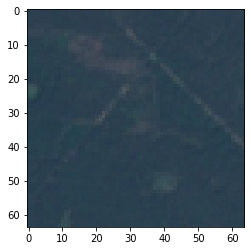

In [8]:
import matplotlib.pyplot as plt

# test the labels and images 
tmp = 20000
img = XImages[tmp]

print(yLabels[tmp])
print(label_names[yLabels[tmp]])
plt.imshow(img);

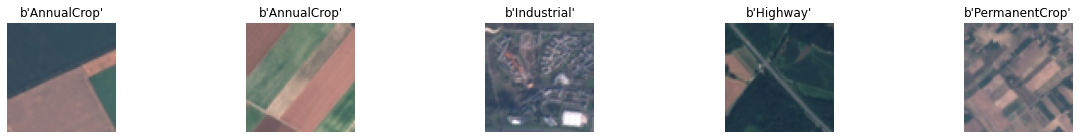

In [9]:
#Select a random sample of images and Plot
import matplotlib.pyplot as plt

num_test_images = XImages.shape[0]
random_inx = np.random.choice(num_test_images, 5)
random_test_images = XImages[random_inx, ...]
random_test_labels = Ylabel[random_inx, ...]

fig, ax = plt.subplots(1, 5, figsize =(20, 2) )
fig.subplots_adjust(hspace=0.2, wspace=0.5)
for i in range (5) :
  ax[i].set_axis_off()
  ax[i].set_title(random_test_labels[i])
  ax[i].imshow(random_test_images[i])

In [10]:
# find the smallest class
smallest_class = np.argmin(np.bincount(yLabels))
smallest_class

5

In [14]:
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer

# number of classes
num_classes = len(np.array(np.unique(yLabels)))
# observations in smallest class
smallest_class_obs = np.where(yLabels == smallest_class)[0]
print(smallest_class_obs.shape)

(2000,)


In [19]:
shuffle(np.where(yLabels == i)[0], random_state=42).shape

(2500,)

In [20]:
shuffle(np.where(yLabels == i)[0], random_state=42)[0:smallest_class_obs.shape[0]].shape

(2000,)

In [21]:
# Get 2000 observations from each class
indBal = np.empty(0, dtype=int)
for i in range(num_classes):
  indTemp = shuffle(np.where(yLabels == i)[0], random_state=42)[0:smallest_class_obs.shape[0]]
  indBal = np.concatenate([indBal, indTemp])

# shuffle the balanced index
indBal = shuffle(indBal, random_state = 42)

In [22]:
indBal.shape

(20000,)

In [49]:
from sklearn.model_selection import train_test_split
#Unbalanced labels
X_train, X_test, y_train, y_test = train_test_split(XImages, yLabels, stratify = yLabels, test_size = 0.5, random_state=42)

b'Industrial'


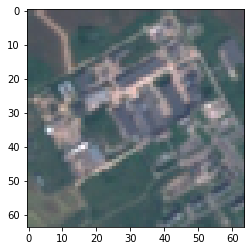

In [54]:
# test that the labels and images 
tmp = 3333
img = X_train[tmp]

print(label_names[y_train[tmp]])
plt.imshow(img); 

In [55]:
yBal = yLabels[indBal]
XBal = XImages[indBal]

print(yBal.shape)
print(XBal.shape)

(20000,)
(20000, 64, 64, 3)


In [56]:
#balanced labels
X_train, X_test, y_train, y_test = train_test_split(XBal, yBal, stratify = yBal, test_size = 0.5, random_state=42)

b'Industrial'


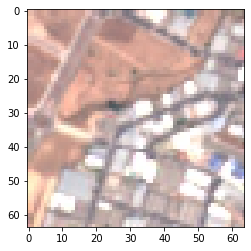

In [57]:
# test that the labels and images 
tmp = 3333
img = X_train[tmp]

print(label_names[y_train[tmp]])
plt.imshow(img);

In [58]:
from tensorflow.keras.utils import to_categorical

# class distribution for yTrain
np.array(np.unique(y_train, return_counts=True)).T

# class distribution for yTest
np.array(np.unique(y_test, return_counts=True)).T

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10000, 64, 64, 3)
(10000, 64, 64, 3)
(10000, 10)
(10000, 10)


In [59]:
# Convert train and test images into 'float64' type

# train_images = train_images.astype('float64')
# test_images = test_images.astype('float64')

# Convert train and test labels into 'int64' type

y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

In [181]:
# Initialize grayscale arrays
X_train_BW = np.zeros([X_train.shape[0],
                       X_train.shape[1],
                       X_train.shape[2]])

X_test_BW = np.zeros([X_test.shape[0],
                      X_test.shape[1],
                      X_test.shape[2]])
print(X_train_BW.shape)
print(X_test_BW.shape)

(10000, 64, 64)
(10000, 64, 64)


In [182]:
#or
X_train_BW = np.average(X_train, axis=-1)
X_test_BW = np.average(X_test, axis=-1)
print(X_train_BW.shape)
print(X_test_BW.shape)

(10000, 64, 64)
(10000, 64, 64)


[b'AnnualCrop' b'AnnualCrop' b'AnnualCrop' b'AnnualCrop' b'AnnualCrop'
 b'Forest' b'AnnualCrop' b'AnnualCrop' b'AnnualCrop' b'AnnualCrop']


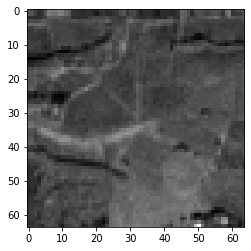

In [185]:
# test that the labels and images 
tmp = 1500
img = X_train_BW[tmp]

print(label_names[y_train[tmp]])
plt.imshow(img, interpolation='nearest', cmap=plt.get_cmap('gray') )

In [184]:
# Add a dummy channel dimension

my_image_train = X_train_BW[..., np.newaxis]
my_image_test = X_test_BW[..., np.newaxis]

from sklearn.preprocessing import LabelBinarizer


# One-hot encoding of train and test labels

# Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. 
# Hint: retain the channel dimension, which will now have size 1.
lb = LabelBinarizer()
my_train_labels = lb.fit_transform(y_train)
my_test_labels = lb.fit_transform(y_test)

print(my_train_labels.shape)
print(my_test_labels.shape)
print(my_image_train.shape)
print (my_image_test.shape)

(10000, 10)
(10000, 10)
(10000, 64, 64, 1)
(10000, 64, 64, 1)


#Data for first model

In [186]:
from skimage.color import rgb2gray

# convert RGB arrays to grayscale
for i in range(X_train.shape[0]):
  X_train_BW[i] = rgb2gray(X_train[i])
  X_test_BW[i] = rgb2gray(X_test[i])

# flatten grayscale arrays
X_train_BW = X_train_BW.reshape(X_train_BW.shape[0],
                                X_train_BW.shape[1] * X_train_BW.shape[2])

X_test_BW = X_test_BW.reshape(X_test_BW.shape[0],
                              X_test_BW.shape[1] * X_test_BW.shape[2])

print(X_train_BW.shape)
print(X_test_BW.shape)
print(y_train.shape)
print(y_test.shape)

(10000, 4096)
(10000, 4096)
(10000, 10)
(10000, 10)


In [187]:
X_train_BW[0].shape

(4096,)

#Build the model

In [73]:
from tensorflow.keras.layers import BatchNormalization, Dropout

In [132]:
def model_1(input_shape) :
  model_1 = Sequential()
  model_1.add(Dense(num_classes, activation = 'softmax', input_shape=(input_shape)))
  
  model_1.compile (optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) ,
                 loss = tf.keras.losses.CategoricalCrossentropy(), 
                 metrics = [tf.keras.metrics.CategoricalAccuracy()])
    
  return model_1

In [133]:
model_1 = model_1(X_train_BW[0].shape)
model_1.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 10)                40970     
Total params: 40,970
Trainable params: 40,970
Non-trainable params: 0
_________________________________________________________________


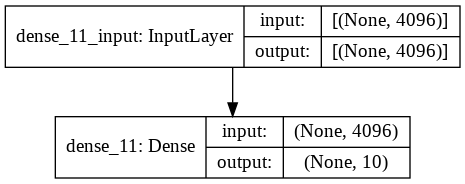

In [116]:
from keras.utils.vis_utils import plot_model
plot_model(model_1, show_shapes=True, show_layer_names=True)

In [127]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint (filepath = '/content/sample_data/checkpoint', monitor = 'val_loss',
                              save_beat_only = True, save_freq = 'epoch', verbose = 1)

In [134]:
history = model_1.fit(X_train_BW,y_train, validation_data= (X_test_BW, y_test) , batch_size=64, epochs=100, callbacks=[checkpoint], verbose=1)

Epoch 1/100
157/157 [==============================] - 1s 6ms/step - loss: 2.2925 - categorical_accuracy: 0.1136 - val_loss: 2.2788 - val_categorical_accuracy: 0.1068

Epoch 00001: saving model to /content/sample_data/checkpoint
INFO:tensorflow:Assets written to: /content/sample_data/checkpoint/assets
Epoch 2/100
157/157 [==============================] - 1s 5ms/step - loss: 2.2640 - categorical_accuracy: 0.1342 - val_loss: 2.2531 - val_categorical_accuracy: 0.1401

Epoch 00002: saving model to /content/sample_data/checkpoint
INFO:tensorflow:Assets written to: /content/sample_data/checkpoint/assets
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 2.2455 - categorical_accuracy: 0.1398 - val_loss: 2.2356 - val_categorical_accuracy: 0.1401

Epoch 00003: saving model to /content/sample_data/checkpoint
INFO:tensorflow:Assets written to: /content/sample_data/checkpoint/assets
Epoch 4/100
157/157 [==============================] - 1s 6ms/step - loss: 2.2312 - categor

In [135]:
score = model_1.evaluate(X_test_BW, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 0s 1ms/step - loss: 2.1163 - categorical_accuracy: 0.2542
Test loss: 2.1162543296813965
Test accuracy: 0.2542000114917755


In [136]:
import pandas as pd
frame = pd.DataFrame(history.history)
frame.head()

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,2.292455,0.1136,2.278755,0.1068
1,2.264030,0.1342,2.253145,0.1401
2,2.245475,0.1398,2.235600,0.1401
3,2.231248,0.1452,2.226037,0.1546
4,2.222441,0.1535,2.217110,0.1498


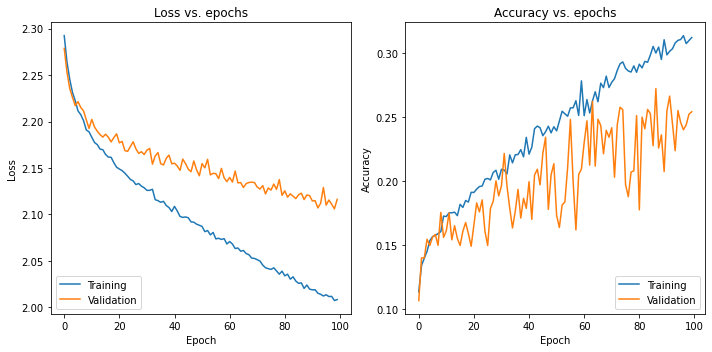

In [137]:
# Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower left')
ax2 = plt.subplot(122)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower right')
plt.tight_layout()
plt.show()

In [141]:
y_test_true_tmp = np.argmax(y_test, axis = 1)
label_count = np.unique(y_test_true_tmp, return_counts = True)[1]

In [144]:
# Define functions for evaluating model accuracy by class and overall

def eval_model_by_class(model, test_set):
  y_test_pred = model.predict(test_set)
  y_test_pred_tmp=np.argmax(y_test_pred,axis=1)

  y_test_true = [label_Dict[x] for x in y_test_true_tmp]
  y_test_pred = [label_Dict[x] for x in y_test_pred_tmp]

  pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
  pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
  pred_df = pred_df.groupby(['y_true']).sum().reset_index()
  pred_df['label_count'] = label_count
  pred_df['class_acc'] = pred_df.accurate_preds / pred_df.label_count
  pred_df = pred_df.sort_values(by = 'class_acc').reset_index()
  pred_df['overall_acc'] = sum(pred_df.accurate_preds) / sum(pred_df.label_count)
  pred_df = pred_df.sort_values('y_true').reset_index(drop = True)

  return(pred_df)

def find_wrong_preds(model, test_set):
  y_test_pred = model.predict(test_set)
  y_test_pred_tmp=np.argmax(y_test_pred,axis=1)

  y_test_true = [label_Dict[x] for x in y_test_true_tmp]
  y_test_pred = [label_Dict[x] for x in y_test_pred_tmp]

  pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
  pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
  # pred_df = pred_df.sort_values('y_true').reset_index(drop = True)
  pred_df = pred_df.sort_values('y_true')

  return(pred_df)

In [145]:
M1_pred_df = eval_model_by_class(model_1, X_test_BW)
M1_pred_df

,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',491,1000,0.491,0.2542
1,1,b'Forest',677,1000,0.677,0.2542
2,2,b'HerbaceousVegetation',17,1000,0.017,0.2542
3,3,b'Highway',235,1000,0.235,0.2542
4,4,b'Industrial',688,1000,0.688,0.2542
5,5,b'Pasture',68,1000,0.068,0.2542
6,6,b'PermanentCrop',89,1000,0.089,0.2542
7,7,b'Residential',5,1000,0.005,0.2542
8,8,b'River',271,1000,0.271,0.2542
9,9,b'SeaLake',1,1000,0.001,0.2542


In [148]:
M1_pred_wrong = find_wrong_preds(model_1, X_test_BW)
M1_pred_wrong

,y_true,y_pred,accurate_preds
702,b'AnnualCrop',b'AnnualCrop',True
5448,b'AnnualCrop',b'AnnualCrop',True
9648,b'AnnualCrop',b'Highway',False
5446,b'AnnualCrop',b'PermanentCrop',False
3077,b'AnnualCrop',b'AnnualCrop',True
...,...,...,...
1810,b'SeaLake',b'Forest',False
5438,b'SeaLake',b'AnnualCrop',False
5450,b'SeaLake',b'Highway',False
3137,b'SeaLake',b'Forest',False


#Second model

In [188]:
my_image_train[0].shape

(64, 64, 1)

In [199]:
def model_2(input_shape, weight_decay_1, weight_decay_2, drop_rate) :
  model_2 = Sequential()
  model_2.add (Conv2D (16, (5,5), activation = 'relu', padding = 'same', name = 'conv_1', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=weight_decay_1, l2=weight_decay_2), input_shape = input_shape))
  model_2.add (BatchNormalization(momentum=0.9, epsilon=0.001))
  model_2.add (Conv2D (16, (5,5), activation = 'relu', padding = 'same', name = 'conv_2', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=weight_decay_1, l2=weight_decay_2)))
  model_2.add (MaxPooling2D ((4,4) , strides=(2,2), name = 'pool_1'))
  model_2.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_3', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=weight_decay_1, l2=weight_decay_2)))
  model_2.add (BatchNormalization(momentum=0.9, epsilon=0.001))
  model_2.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_4', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=weight_decay_1, l2=weight_decay_2)))
  model_2.add (MaxPooling2D ((4,4) , strides=(2,2),name = 'pool_2'))
  model_2.add (Dropout(rate = drop_rate))
  model_2.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_5', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1(weight_decay_1)))
  model_2.add (BatchNormalization(momentum=0.9, epsilon=0.001))
  model_2.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_6', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1(l1=weight_decay_1)))
  model_2.add (MaxPooling2D ((4,4) , strides=(2,2),name = 'pool_3'))
  model_2.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_7', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1(l1=weight_decay_1)))
  model_2.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_8', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1(l1=weight_decay_1)))
  model_2.add (MaxPooling2D ((4,4) , strides=(2,2),name = 'pool_4'))
  model_2.add (Dropout(rate = drop_rate))
  model_2.add (Flatten ())
  model_2.add (Dense (num_classes, activation = 'relu', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1(l1=weight_decay_1) , name = 'dense_1') )
  model_2.add (Dropout(rate = drop_rate))
  model_2.add (Dense (10, activation = 'softmax', name = 'dense_2') )
  
  model_2.compile (optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) ,
                 loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                 metrics = [tf.keras.metrics.CategoricalAccuracy()])
  
  return model_2

In [200]:
model_2 = model_2(my_image_train[0].shape, 1e-8, 0.0001, 0.05)
model_2.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 64, 64, 16)        416       
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
conv_2 (Conv2D)              (None, 64, 64, 16)        6416      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 31, 31, 16)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 31, 31, 16)        2320      
_________________________________________________________________
batch_normalization_5 (Batch (None, 31, 31, 16)        64        
_________________________________________________________________
conv_4 (Conv2D)              (None, 31, 31, 16)      

In [204]:
from tensorflow.keras.callbacks import EarlyStopping

checkpoint = ModelCheckpoint (filepath = '/content/sample_data/checkpoint/checkpoint', monitor = 'val_loss',
                              save_weights_only = True,save_beat_only = True, save_freq = 'epoch', verbose = 1)

early = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'max', min_delta = 5, verbose = 1 )

call = [checkpoint, early]

In [205]:
history_2 = model_2.fit(my_image_train,my_train_labels, validation_data= (my_image_test, my_test_labels) , batch_size=64, epochs=100, callbacks=call, verbose=1)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


157/157 [==============================] - 181s 1s/step - loss: 3.4710 - categorical_accuracy: 0.1438 - val_loss: 2.0272 - val_categorical_accuracy: 0.2581

Epoch 00001: saving model to /content/sample_data/checkpoint/checkpoint
Epoch 2/100
157/157 [==============================] - 178s 1s/step - loss: 2.1207 - categorical_accuracy: 0.2053 - val_loss: 1.9655 - val_categorical_accuracy: 0.2800

Epoch 00002: saving model to /content/sample_data/checkpoint/checkpoint
Epoch 3/100
157/157 [==============================] - 178s 1s/step - loss: 2.0405 - categorical_accuracy: 0.2491 - val_loss: 1.8618 - val_categorical_accuracy: 0.2997

Epoch 00003: saving model to /content/sample_data/checkpoint/checkpoint
Epoch 4/100
157/157 [==============================] - 177s 1s/step - loss: 1.9626 - categorical_accuracy: 0.2837 - val_loss: 1.7775 - val_categorical_accuracy: 0.3344

Epoch 00004: saving model to /content/sample_data/checkpoint/checkpoint
Epoch 5/100
157/157 [===========================

In [206]:
score = model_2.evaluate(my_image_test, my_test_labels, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 33s 106ms/step - loss: 1.2716 - categorical_accuracy: 0.5470
Test loss: 1.2716354131698608
Test accuracy: 0.546999990940094


In [207]:
import pandas as pd
frame_2 = pd.DataFrame(history_2.history)
frame_2.head()

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,3.470984,0.1438,2.027192,0.2581
1,2.120742,0.2053,1.965509,0.2800
2,2.040466,0.2491,1.861799,0.2997
3,1.962565,0.2837,1.777497,0.3344
4,1.891421,0.3133,1.703489,0.3718


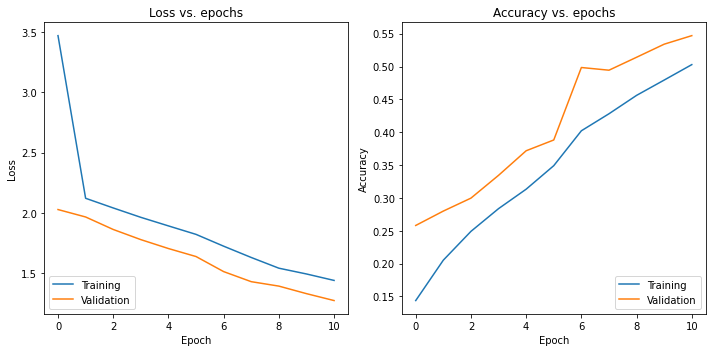

In [208]:
# Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower left')
ax2 = plt.subplot(122)
plt.plot(history_2.history['categorical_accuracy'])
plt.plot(history_2.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower right')
plt.tight_layout()
plt.show()

In [209]:
M2_pred_df_2 = eval_model_by_class(model_2, my_image_test)
M2_pred_df_2

,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',796,1000,0.796,0.547
1,1,b'Forest',895,1000,0.895,0.547
2,2,b'HerbaceousVegetation',109,1000,0.109,0.547
3,3,b'Highway',340,1000,0.340,0.547
4,4,b'Industrial',925,1000,0.925,0.547
5,5,b'Pasture',13,1000,0.013,0.547
6,6,b'PermanentCrop',501,1000,0.501,0.547
7,7,b'Residential',944,1000,0.944,0.547
8,8,b'River',4,1000,0.004,0.547
9,9,b'SeaLake',943,1000,0.943,0.547


In [210]:
M2_pred_wrong = find_wrong_preds(model_2, my_image_test)
M2_pred_wrong

,y_true,y_pred,accurate_preds
702,b'AnnualCrop',b'AnnualCrop',True
5448,b'AnnualCrop',b'Highway',False
9648,b'AnnualCrop',b'Forest',False
5446,b'AnnualCrop',b'AnnualCrop',True
3077,b'AnnualCrop',b'AnnualCrop',True
...,...,...,...
1810,b'SeaLake',b'SeaLake',True
5438,b'SeaLake',b'SeaLake',True
5450,b'SeaLake',b'Forest',False
3137,b'SeaLake',b'SeaLake',True


In [215]:
def model_3(input_shape, drop_rate) :
  model_3 = Sequential() 
  model_3.add( Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(input_shape)) )
  model_3.add(BatchNormalization())
  model_3.add( Conv2D(32, (3, 3), padding='same', activation='relu') )
  model_3.add( MaxPooling2D((2, 2)) )
  model_3.add( Dropout(drop_rate) )
  model_3.add( Conv2D(64, (3, 3), padding='same', activation='relu') )
  model_3.add( BatchNormalization())
  model_3.add( Conv2D(64, (3, 3), padding='same', activation='relu') )
  model_3.add( MaxPooling2D((2, 2)) )
  model_3.add( Dropout(drop_rate) )
  model_3.add( Conv2D(128, (3, 3), padding='same', activation='relu') )
  model_3.add( BatchNormalization() )
  model_3.add( Conv2D(128, (3, 3), padding='same', activation='relu') )
  model_3.add( MaxPooling2D((2, 2)) )
  model_3.add( Dropout(drop_rate) )
  model_3.add( Flatten() )
  model_3.add( Dense(128, activation='relu') )
  model_3.add( Dropout(drop_rate) )    
  model_3.add( Dense(10,  activation='softmax') )
  
  model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])
  
  return model_3 

In [216]:
model_3 = model_3(my_image_train[0].shape, 0.3)
model_3.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
batch_normalization_10 (Batc (None, 64, 64, 16)        64        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 32, 64)      

In [217]:
history_3 = model_3.fit(my_image_train, my_train_labels, validation_data=(my_image_test, my_test_labels), 
                        epochs=100, batch_size=64,callbacks=call, verbose=1)

Epoch 1/100
157/157 [==============================] - 307s 2s/step - loss: 1.9291 - categorical_accuracy: 0.2997 - val_loss: 2.5994 - val_categorical_accuracy: 0.0792

Epoch 00001: saving model to /content/sample_data/checkpoint/checkpoint
Epoch 2/100
157/157 [==============================] - 307s 2s/step - loss: 1.5263 - categorical_accuracy: 0.4283 - val_loss: 2.9738 - val_categorical_accuracy: 0.1280

Epoch 00002: saving model to /content/sample_data/checkpoint/checkpoint
Epoch 3/100
157/157 [==============================] - 305s 2s/step - loss: 1.3552 - categorical_accuracy: 0.5003 - val_loss: 2.8256 - val_categorical_accuracy: 0.1729

Epoch 00003: saving model to /content/sample_data/checkpoint/checkpoint
Epoch 4/100
157/157 [==============================] - 305s 2s/step - loss: 1.2059 - categorical_accuracy: 0.5705 - val_loss: 1.7561 - val_categorical_accuracy: 0.3964

Epoch 00004: saving model to /content/sample_data/checkpoint/checkpoint
Epoch 5/100
157/157 [===============

In [218]:
score = model_3.evaluate(my_image_test, my_test_labels, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 62s 198ms/step - loss: 1.1205 - categorical_accuracy: 0.6057
Test loss: 1.1205109357833862
Test accuracy: 0.6057000160217285


In [219]:

frame_3 = pd.DataFrame(history_3.history)
frame_3.head()

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,1.929145,0.2997,2.599350,0.0792
1,1.526254,0.4283,2.973849,0.1280
2,1.355216,0.5003,2.825645,0.1729
3,1.205942,0.5705,1.756075,0.3964
4,1.056901,0.6247,1.431003,0.5128


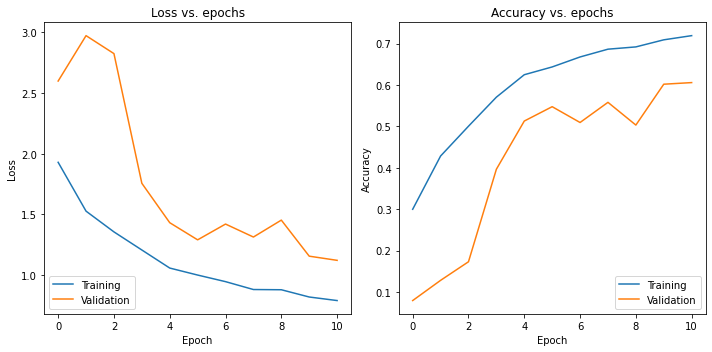

In [220]:
# Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower left')
ax2 = plt.subplot(122)
plt.plot(history_3.history['categorical_accuracy'])
plt.plot(history_3.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower right')
plt.tight_layout()
plt.show()

In [221]:
M2_pred_df_3 = eval_model_by_class(model_3, my_image_test)
M2_pred_df_3

,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',611,1000,0.611,0.6057
1,1,b'Forest',977,1000,0.977,0.6057
2,2,b'HerbaceousVegetation',801,1000,0.801,0.6057
3,3,b'Highway',270,1000,0.270,0.6057
4,4,b'Industrial',249,1000,0.249,0.6057
5,5,b'Pasture',344,1000,0.344,0.6057
6,6,b'PermanentCrop',470,1000,0.470,0.6057
7,7,b'Residential',979,1000,0.979,0.6057
8,8,b'River',378,1000,0.378,0.6057
9,9,b'SeaLake',978,1000,0.978,0.6057


In [222]:
M3_pred_wrong = find_wrong_preds(model_3, my_image_test)
M3_pred_wrong

,y_true,y_pred,accurate_preds
702,b'AnnualCrop',b'AnnualCrop',True
5448,b'AnnualCrop',b'PermanentCrop',False
9648,b'AnnualCrop',b'Pasture',False
5446,b'AnnualCrop',b'AnnualCrop',True
3077,b'AnnualCrop',b'HerbaceousVegetation',False
...,...,...,...
1810,b'SeaLake',b'SeaLake',True
5438,b'SeaLake',b'SeaLake',True
5450,b'SeaLake',b'SeaLake',True
3137,b'SeaLake',b'SeaLake',True


#Fourth model

In [223]:
def model_4 (input_shape) :
  model_4 = Sequential ()
  model_4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  model_4.add(MaxPooling2D(pool_size=(2, 2)))
  model_4.add(Conv2D(64, (3, 3), activation='relu'))
  model_4.add(MaxPooling2D(pool_size=(2, 2)))
  model_4.add(Conv2D(128, (3, 3), activation='relu'))
  model_4.add(MaxPooling2D(pool_size=(2, 2)))
  model_4.add(Conv2D(256, (3, 3), activation='relu'))
  model_4.add(MaxPooling2D(pool_size=(2, 2)))
  model_4.add(Flatten())
  model_4.add(Dropout(0.5))
  model_4.add(Dense(512, activation='relu'))
  model_4.add(Dense(num_classes, activation='softmax'))

  model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])
  
  return model_4 

In [225]:
model_4 = model_4(my_image_train[0].shape)
model_4.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 256)       

In [226]:
history_4 = model_4.fit(my_image_train,my_train_labels, validation_data= (my_image_test, my_test_labels) , 
                        batch_size=64, epochs=100, callbacks=call, verbose=1)

Epoch 1/100
157/157 [==============================] - 91s 577ms/step - loss: 2.1348 - categorical_accuracy: 0.1559 - val_loss: 1.7794 - val_categorical_accuracy: 0.3118

Epoch 00001: saving model to /content/sample_data/checkpoint/checkpoint
Epoch 2/100
157/157 [==============================] - 91s 580ms/step - loss: 1.6146 - categorical_accuracy: 0.3451 - val_loss: 1.4487 - val_categorical_accuracy: 0.4032

Epoch 00002: saving model to /content/sample_data/checkpoint/checkpoint
Epoch 3/100
157/157 [==============================] - 91s 580ms/step - loss: 1.4521 - categorical_accuracy: 0.4129 - val_loss: 1.3538 - val_categorical_accuracy: 0.4464

Epoch 00003: saving model to /content/sample_data/checkpoint/checkpoint
Epoch 4/100
157/157 [==============================] - 91s 578ms/step - loss: 1.3425 - categorical_accuracy: 0.4928 - val_loss: 1.2393 - val_categorical_accuracy: 0.5514

Epoch 00004: saving model to /content/sample_data/checkpoint/checkpoint
Epoch 5/100
157/157 [=======

In [227]:
score = model_4.evaluate(my_image_test, my_test_labels, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 19s 61ms/step - loss: 0.8799 - categorical_accuracy: 0.6808
Test loss: 0.8799192309379578
Test accuracy: 0.6808000206947327


In [228]:
frame_4 = pd.DataFrame(history_4.history)
frame_4.head()

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,2.134832,0.1559,1.779397,0.3118
1,1.614592,0.3451,1.448684,0.4032
2,1.452126,0.4129,1.353849,0.4464
3,1.342467,0.4928,1.239306,0.5514
4,1.224889,0.5559,1.087591,0.6258


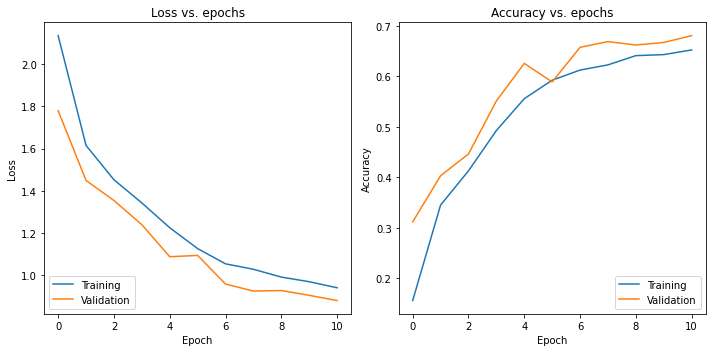

In [229]:
# Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower left')
ax2 = plt.subplot(122)
plt.plot(history_4.history['categorical_accuracy'])
plt.plot(history_4.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower right')
plt.tight_layout()
plt.show()

In [230]:
M2_pred_df_4 = eval_model_by_class(model_4, my_image_test)
M2_pred_df_4

,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',732,1000,0.732,0.6808
1,1,b'Forest',918,1000,0.918,0.6808
2,2,b'HerbaceousVegetation',180,1000,0.180,0.6808
3,3,b'Highway',422,1000,0.422,0.6808
4,4,b'Industrial',911,1000,0.911,0.6808
5,5,b'Pasture',698,1000,0.698,0.6808
6,6,b'PermanentCrop',678,1000,0.678,0.6808
7,7,b'Residential',932,1000,0.932,0.6808
8,8,b'River',395,1000,0.395,0.6808
9,9,b'SeaLake',942,1000,0.942,0.6808


In [ ]:
from keras.utils import plot_model
plot_convolutional_filters(img)

In [ ]:
import tensorflow_datasets.public_api as tfds

tfds.list_builders()